# Import packages

In [1]:
import pandas as pd
import Geohash
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import random
import pickle

# Import data

In [2]:
data = pd.read_csv('training.csv')

In [3]:
data.head()

geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468

# Define Data class

In [ ]:
class Data:
    def __init__(self, train_data, geohash):
        self.geohash = geohash
        self.latitude, self.longitude = Geohash.decode(self.geohash)
        temp = self.extract_hour_minute(train_data[['day','timestamp','demand']])
        self.train_data = self.impute_zero_demand(temp)
        self.test_data = None
    
    
    def extract_hour_minute(self, data):
        hour, minute = zip(*[timestamp.split(':') for timestamp in data['timestamp']])
        data['hour'] = [int(item) for item in hour]
        data['minute'] = [int(item) for item in minute]
        data.drop(columns=['timestamp'], inplace=True)
        return data.sort_values(by=['day','hour','minute']).reset_index(drop=True)
    
    
    def impute_zero_demand(self, data):
        day_list = list(data.groupby('day').groups.keys())
        hour_list = list(range(0, 24, 1))
        minute_list = list(range(0, 60, 15))
        
        time_interval = np.asarray([[day,hour,minute] for day in day_list for hour in hour_list for minute in minute_list], dtype=np.int32)
        new_data = np.hstack((time_interval, np.zeros(shape=(time_interval.shape[0],1))))
        
        for i in range(len(data)):
            index = np.where((new_data[:,0] == data.loc[i,'day']) & (new_data[:,1] == data.loc[i,'hour']) & (new_data[:,2] == data.loc[i,'minute']))
            new_data[index, 3] = data.loc[i,'demand']
            
        return pd.DataFrame(data=new_data, columns=['day','hour','minute','demand'])
    
    
    def plot_demand(self, day):
        tick_loc = list(range(0,97,4))
        tick_label = list(range(0,25))
        try:
            grouped_data = self.train_data.groupby('day').get_group(day)
            sns.lineplot(x=list(range(len(grouped_data))), y=grouped_data['demand'])
            plt.xlabel('Time')
            plt.ylabel('Normalised Demand')
            plt.title('Demand VS Time')
            plt.xticks(tick_loc, tick_label)
        except KeyError:
            pass
        
        
    def data_by_time(self, days):
        hour_list = list(range(0, 24, 1))
        minute_list = list(range(0, 60, 15))
        time_interval = [[hour,minute] for hour in hour_list for minute in minute_list]
        
        for day in days:
            try:
                data_array = np.vstack((data_array, self.train_data.groupby('day').get_group(day).values))
            except KeyError:
                pass
            except NameError:
                try:
                    data_array = self.train_data.groupby('day').get_group(day).values
                except KeyError:
                    pass
    
        for hour, minute in time_interval:
            index = np.where((data_array[:,1] == hour) & (data_array[:,2] == minute))
            
            if hour == 0 and minute == 0:
                data_by_time = data_array[index,3].reshape(-1,1)
            else: 
                data_by_time = np.hstack((data_by_time, data_array[index,3].reshape(-1,1)))
        
        return pd.DataFrame(data_by_time, columns=[str(time[0])+':'+str(time[1]) for time in time_interval])
        
        
    def set_test_data(self, test_data):
        temp = self.extract_hour_minute(test_data[['day','timestamp','demand']])
        self.test_data = self.impute_zero_demand(temp)
        
        
    def next_batch(self, batch_size, num_time_steps, steps_ahead, training=True):
        if training:
            data = self.train_data
        else:
            data = self.test_data
            
        input_columns = ['demand']
        input_dim = len(input_columns)
        rand_start = random.choices(population=range(len(data)-num_time_steps-steps_ahead), k=batch_size) ## randomly initialise the starting point between the first index to the (last index - num_time_steps - steps_ahead)
        y_batch = data[input_columns].values.transpose()
        y_batch = np.asarray([y_batch[:,i:i+num_time_steps+steps_ahead].reshape(num_time_steps+steps_ahead,input_dim) for i in rand_start])

        return y_batch[:,:-steps_ahead,:], y_batch[:,steps_ahead:,:]
        
        
    def test_batch(self, num_time_steps, steps_ahead):
        if self.test_data is None:
            raise ValueError('Test data is not initialised.')
           
        input_columns = ['demand']
        input_dim = len(input_columns)
        start_index = list(range(0, len(self.test_data)-num_time_steps-steps_ahead, num_time_steps+steps_ahead))
        start_index.append(len(self.test_data)-num_time_steps-steps_ahead)  # this ensures that the last few data points are predicted as well
        test_batch = self.test_data[input_columns].values.transpose()
        test_batch = np.asarray([test_batch[:,i:i+num_time_steps+steps_ahead].reshape(num_time_steps+steps_ahead,input_dim) for i in start_index])
        
        return test_batch[:,:-steps_ahead,:], test_batch[:,steps_ahead:,:] 

# Data segmentation based on geolocation and perform train validation split

In [5]:
geohash_list = list(data.groupby('geohash6').groups.keys())
data_list = []
gb = data.groupby('geohash6')
train_fraction = 1 - ((len(set(data['day']))/8.0) / len(set(data['day'])))  # the last week of data will be used as test data

for i in tqdm(range(len(geohash_list))):
    data_segment = gb.get_group(geohash_list[i])
    day_list = list(data_segment.groupby('day').groups.keys())
    train_size = int(len(day_list) * train_fraction)

    if train_size == 0:
        train_day = day_list
        validation_day = day_list
    else:
        train_day = day_list[:train_size]
        validation_day = day_list[train_size:]

    train_data_segment = data_segment.loc[data_segment['day'].isin(train_day)].reset_index(drop=True)
    validation_data_segment = data_segment.loc[data_segment['day'].isin(validation_day)].reset_index(drop=True)
    
    data_object = Data(train_data_segment, geohash_list[i])
    data_object.set_test_data(validation_data_segment)
    data_list.append(data_object)
    
    if i == 0:
        validation_data = validation_data_segment
    else:
        validation_data = pd.concat([validation_data, validation_data_segment], ignore_index=True)
    
validation_data.to_csv('validation.csv', index=False)

100%|██████████| 1329/1329 [10:05<00:00,  3.14it/s]


# Define Model class

In [6]:
class Model:
    def __init__(self, data, geohash):
        self.geohash = geohash
        self.data = data
        self.batch_size = 100
        self.num_time_steps = 20
        self.steps_ahead = 5  # the model predicts up to 5 time steps forward in time
        self.num_neurons = self.num_time_steps
        self.input_dim = 1  # input is just the demand for now.
        self.output_dim = 1
        self.learning_rate = 0.001
        self.epoch = 10000
        self.num_layers = 3
        
    
    def train_model(self):
        tf.reset_default_graph()
        
        # Define RNN architecture
        X = tf.placeholder(tf.float32, [None, self.num_time_steps, self.input_dim])
        y = tf.placeholder(tf.float32, [None, self.num_time_steps, self.output_dim])
        
        cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=self.num_neurons) for layer in range(self.num_layers)])
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        final_outputs = tf.nn.relu(tf.reshape(outputs[:,-1,:], [self.batch_size,self.num_time_steps,self.output_dim]))
        
        # Define loss function (MSE)
        loss = tf.reduce_mean(tf.square(final_outputs-y))
        
        # Initialise optimiser
        optimiser = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        # Initialise global variables and start training
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        train_mse_list = []
        test_mse_list = []

        for iteration in tqdm(range(self.epoch)):
            X_train_batch, y_train_batch = self.data.next_batch(batch_size=self.batch_size, num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead)
            sess.run(optimiser, feed_dict={X:X_train_batch, y:y_train_batch})
                
            if iteration % 100 == 0:
                train_mse = loss.eval(feed_dict={X:X_train_batch, y:y_train_batch})
                train_mse_list.append(train_mse)
                
                X_test_batch, y_test_batch = self.data.next_batch(batch_size=self.batch_size, num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead, training=False)
                test_prediction, test_mse = sess.run([final_outputs,loss],feed_dict={X:X_test_batch, y:y_test_batch})
                test_mse_list.append(test_mse)
            
        # Save model
        saver.save(sess, './models/' + self.geohash)
        sess.close()
        
        # Plot MSE graph
        sns.lineplot(x=list(range(len(train_mse_list))), y=train_mse_list, label='Training')
        sns.lineplot(x=list(range(len(test_mse_list))), y=test_mse_list, label='Test')
        plt.show()
        
        
    def test_model(self):
        tf.reset_default_graph()
        
        # Initialise test session and global variables
        sess = tf.InteractiveSession()
        saver = tf.train.Saver()
        saver.restore(sess, './models/' + self.geohash)
        sess.run(tf.global_variables_initializer())
        
        # Start testing
        X_test_batch, y_test_batch = self.data.test_batch(num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead)
        test_mse = loss.eval(feed_dict={X:X_test_batch, y:y_test_batch})

        sess.close()
        
        return test_mse

# Train models according to geolocation

Training 1 out of 1329


100%|██████████| 10000/10000 [04:47<00:00, 34.81it/s]


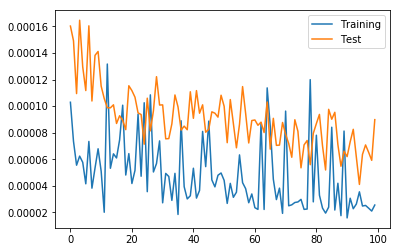

Training 2 out of 1329


100%|██████████| 10000/10000 [04:56<00:00, 33.74it/s]


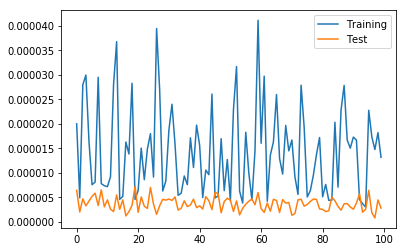

Training 3 out of 1329


100%|██████████| 10000/10000 [04:50<00:00, 34.48it/s]


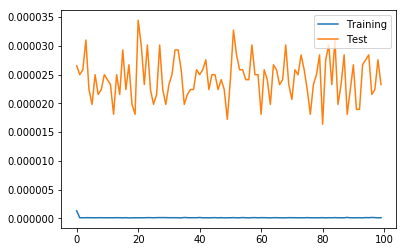

Training 4 out of 1329


100%|██████████| 10000/10000 [05:04<00:00, 32.87it/s]


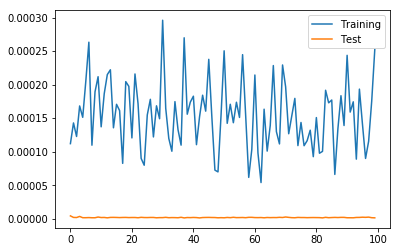

Training 5 out of 1329


100%|██████████| 10000/10000 [04:36<00:00, 36.13it/s]


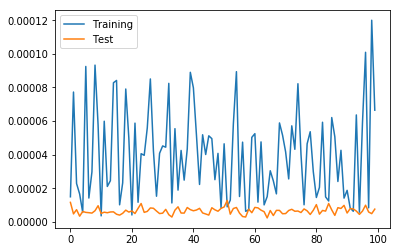

Training 6 out of 1329


100%|██████████| 10000/10000 [04:13<00:00, 39.45it/s]


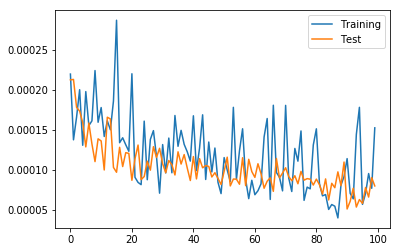

Training 7 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.91it/s]


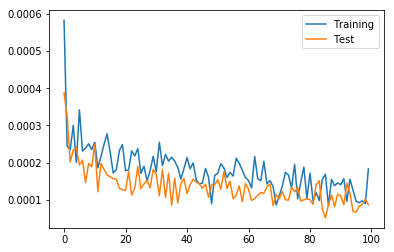

Training 8 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.02it/s]


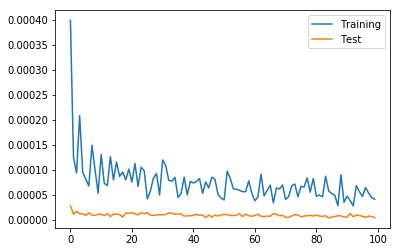

Training 9 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.61it/s]


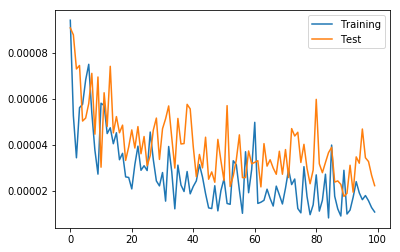

Training 10 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.64it/s]


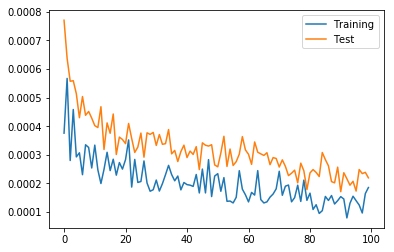

Training 11 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.71it/s]


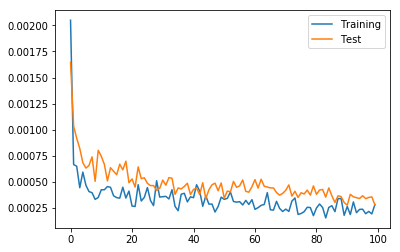

Training 12 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.56it/s]


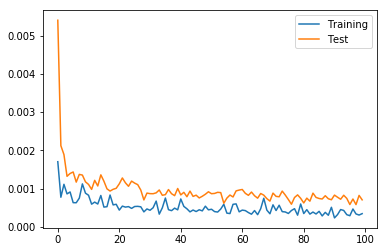

Training 13 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.62it/s]


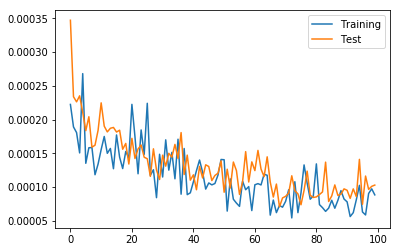

Training 14 out of 1329


100%|██████████| 10000/10000 [04:20<00:00, 38.33it/s]


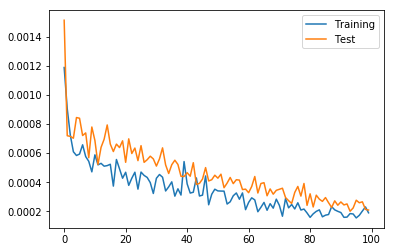

Training 15 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.58it/s]


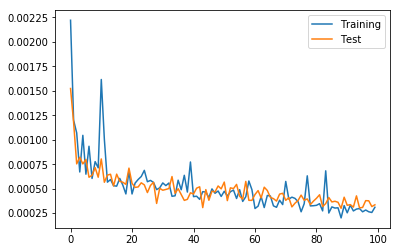

Training 16 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.37it/s]


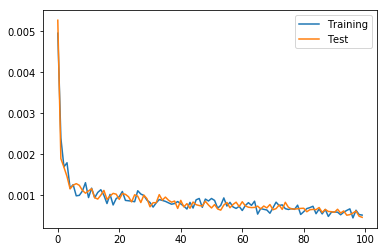

Training 17 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.53it/s]


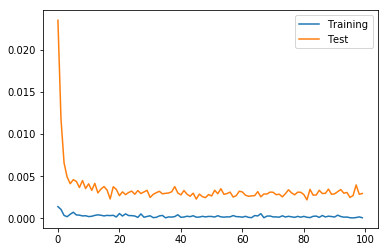

Training 18 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.50it/s]


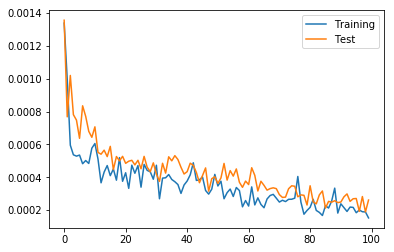

Training 19 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 39.03it/s]


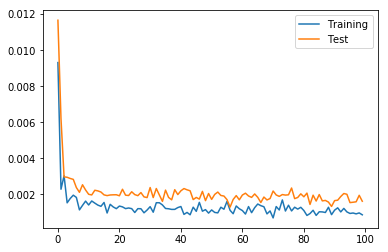

Training 20 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.60it/s]


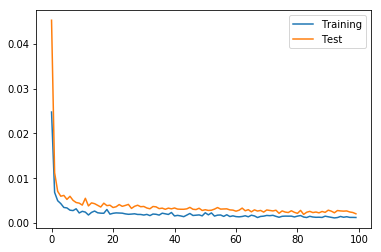

Training 21 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.70it/s]


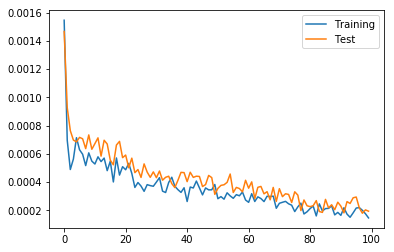

Training 22 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.47it/s]


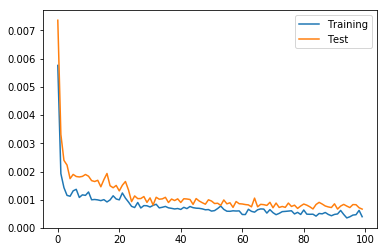

Training 23 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.76it/s]


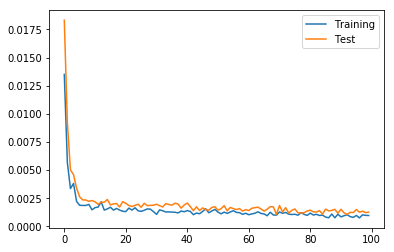

Training 24 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.71it/s]


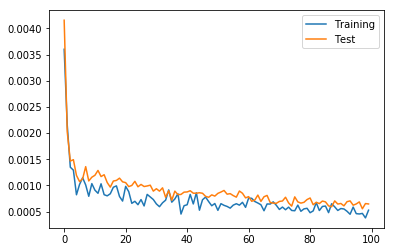

Training 25 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.65it/s]


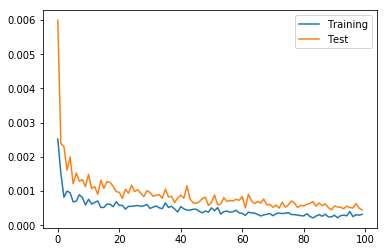

Training 26 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.28it/s]


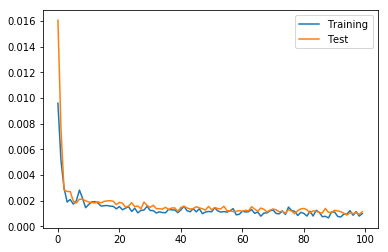

Training 27 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.60it/s]


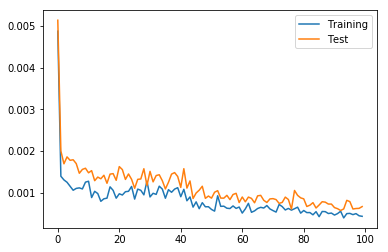

Training 28 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.75it/s]


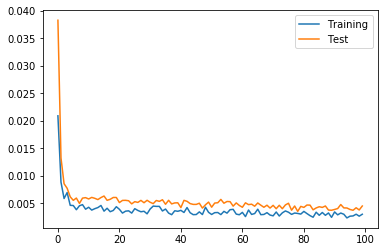

Training 29 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.16it/s]


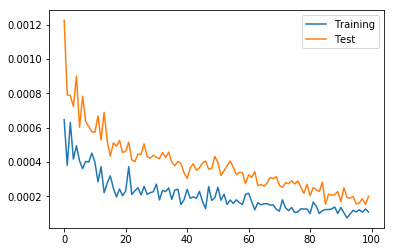

Training 30 out of 1329


100%|██████████| 10000/10000 [04:27<00:00, 37.40it/s]


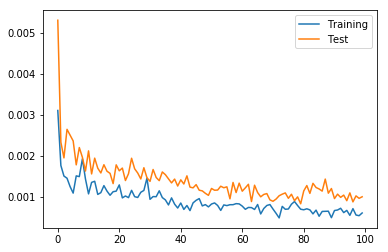

Training 31 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.07it/s]


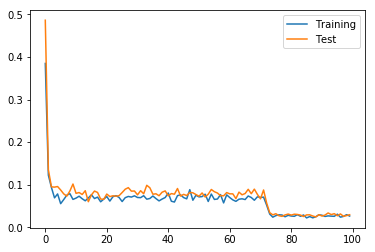

Training 32 out of 1329


100%|██████████| 10000/10000 [04:27<00:00, 35.85it/s]


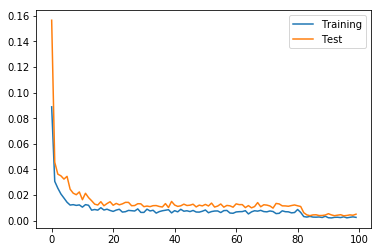

Training 33 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.61it/s]


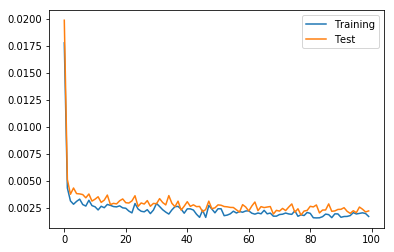

Training 34 out of 1329


100%|██████████| 10000/10000 [04:32<00:00, 35.30it/s]


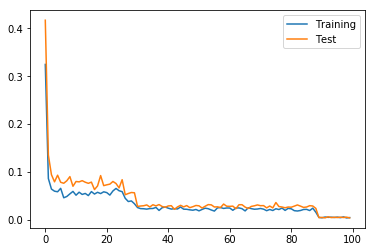

Training 35 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.60it/s]


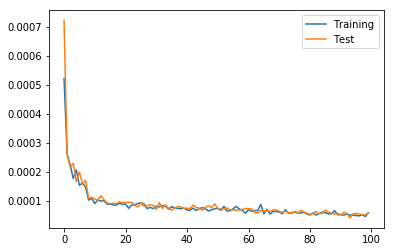

Training 36 out of 1329


100%|██████████| 10000/10000 [04:34<00:00, 36.37it/s]


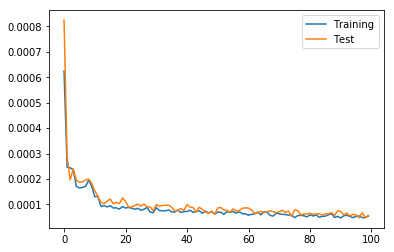

Training 37 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.20it/s]


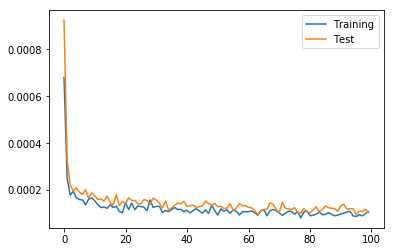

Training 38 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.82it/s]


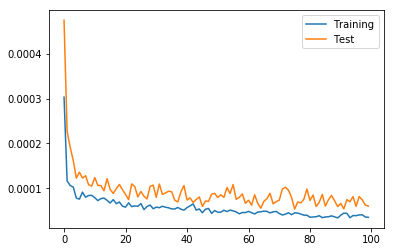

Training 39 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.80it/s]


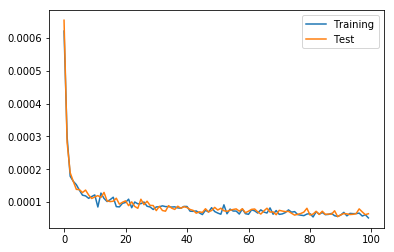

Training 40 out of 1329


100%|██████████| 10000/10000 [04:16<00:00, 38.99it/s]


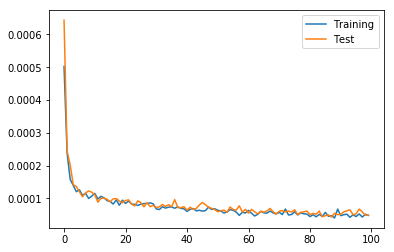

Training 41 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.72it/s]


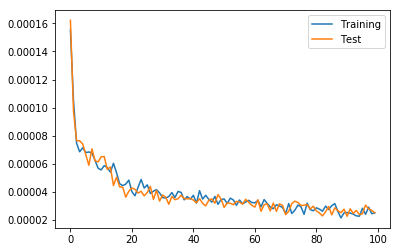

Training 42 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.26it/s]


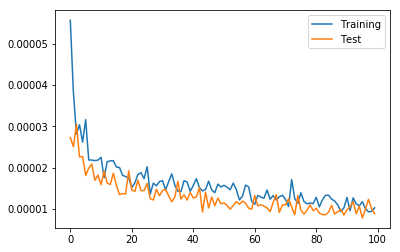

Training 43 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.28it/s]


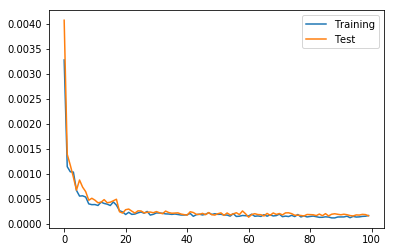

Training 44 out of 1329


100%|██████████| 10000/10000 [04:35<00:00, 37.86it/s]


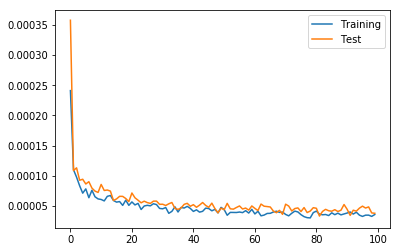

Training 45 out of 1329


100%|██████████| 10000/10000 [04:38<00:00, 35.94it/s]


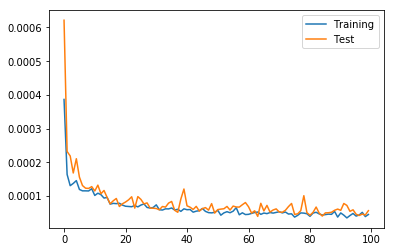

Training 46 out of 1329


100%|██████████| 10000/10000 [04:38<00:00, 35.87it/s]


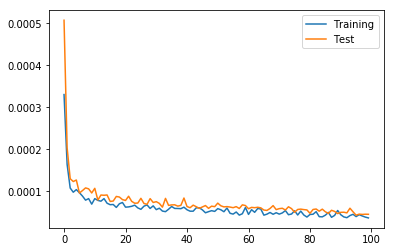

Training 47 out of 1329


100%|██████████| 10000/10000 [04:43<00:00, 35.28it/s]


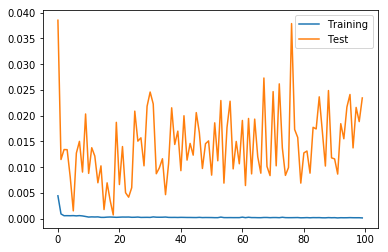

Training 48 out of 1329


100%|██████████| 10000/10000 [04:48<00:00, 34.67it/s]


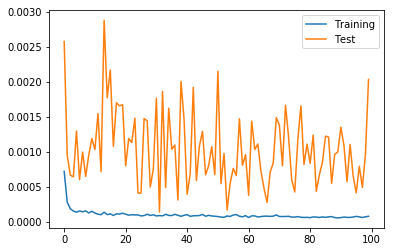

Training 49 out of 1329


100%|██████████| 10000/10000 [04:44<00:00, 35.21it/s]


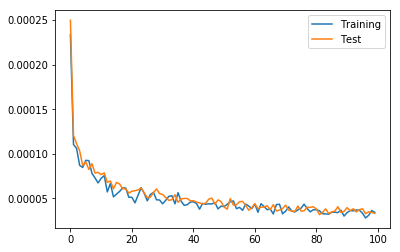

Training 50 out of 1329


100%|██████████| 10000/10000 [04:42<00:00, 35.57it/s]


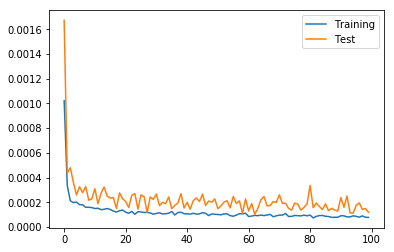

Training 51 out of 1329


100%|██████████| 10000/10000 [04:34<00:00, 36.41it/s]


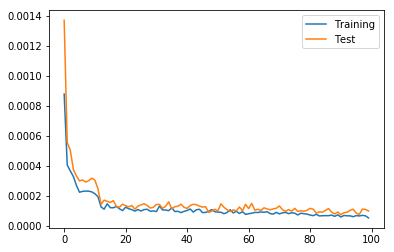

Training 52 out of 1329


100%|██████████| 10000/10000 [04:27<00:00, 37.04it/s]


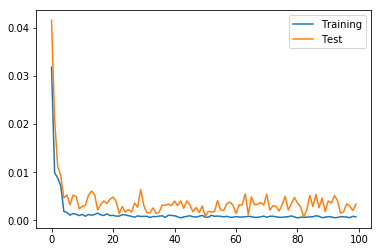

Training 53 out of 1329


100%|██████████| 10000/10000 [04:37<00:00, 36.04it/s]


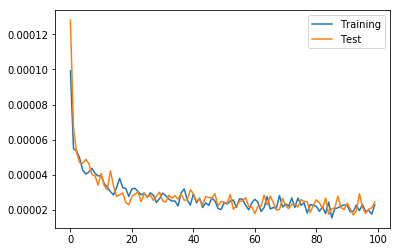

Training 54 out of 1329


100%|██████████| 10000/10000 [04:41<00:00, 35.55it/s]


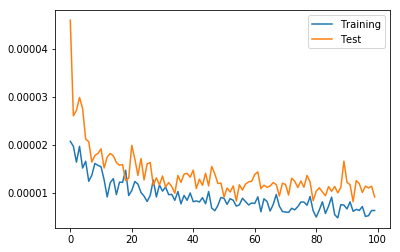

Training 55 out of 1329


100%|██████████| 10000/10000 [04:37<00:00, 36.08it/s]


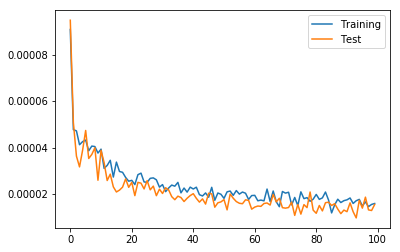

Training 56 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.65it/s]


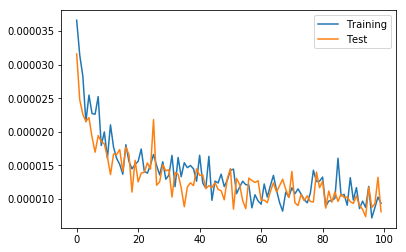

Training 57 out of 1329


100%|██████████| 10000/10000 [04:20<00:00, 38.32it/s]


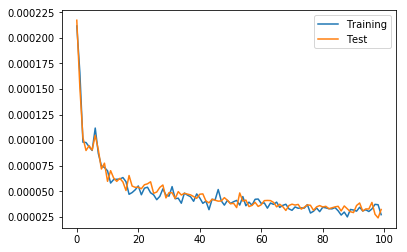

Training 58 out of 1329


100%|██████████| 10000/10000 [04:28<00:00, 37.24it/s]


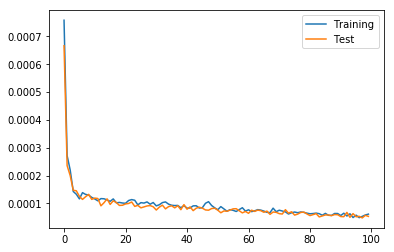

Training 59 out of 1329


100%|██████████| 10000/10000 [04:36<00:00, 36.16it/s]


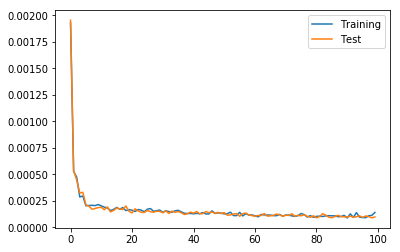

Training 60 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.61it/s]


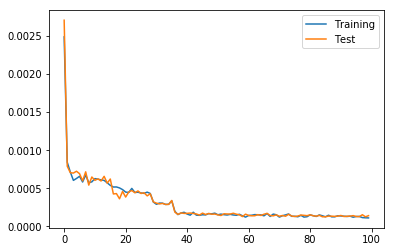

Training 61 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.27it/s]


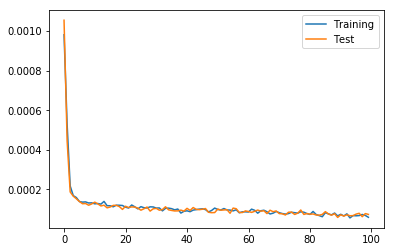

Training 62 out of 1329


100%|██████████| 10000/10000 [04:45<00:00, 35.05it/s]


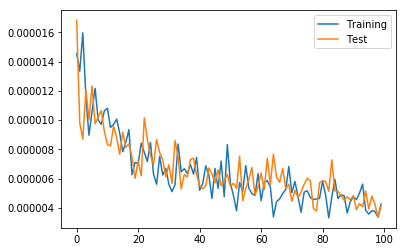

Training 63 out of 1329


100%|██████████| 10000/10000 [04:37<00:00, 37.14it/s]


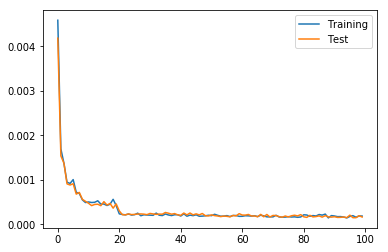

Training 64 out of 1329


100%|██████████| 10000/10000 [04:40<00:00, 35.69it/s]


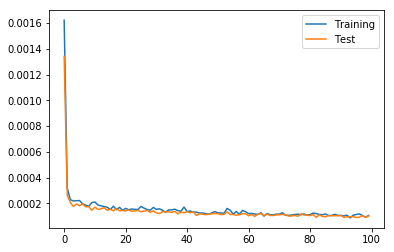

Training 65 out of 1329


100%|██████████| 10000/10000 [04:40<00:00, 35.96it/s]


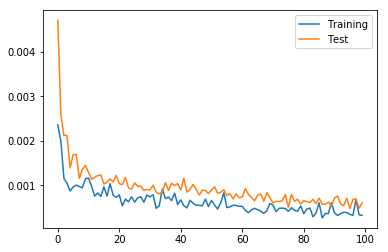

Training 66 out of 1329


100%|██████████| 10000/10000 [04:41<00:00, 35.56it/s]


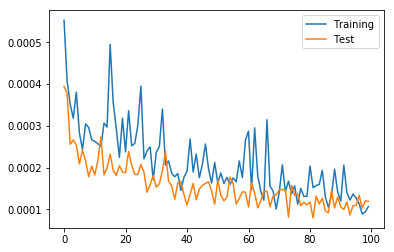

Training 67 out of 1329


100%|██████████| 10000/10000 [04:33<00:00, 36.62it/s]


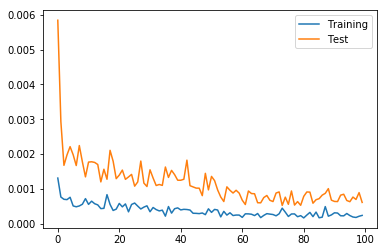

Training 68 out of 1329


100%|██████████| 10000/10000 [04:47<00:00, 34.83it/s]


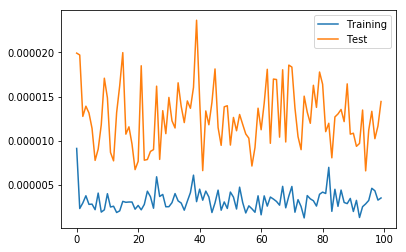

Training 69 out of 1329


100%|██████████| 10000/10000 [05:06<00:00, 32.66it/s]


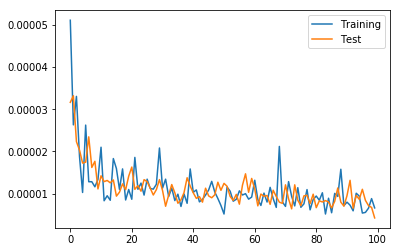

Training 70 out of 1329


100%|██████████| 10000/10000 [05:05<00:00, 32.76it/s]


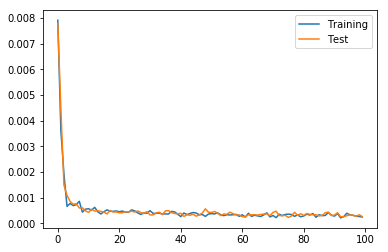

Training 71 out of 1329


100%|██████████| 10000/10000 [05:03<00:00, 32.90it/s]


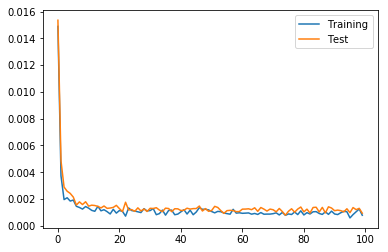

Training 72 out of 1329


100%|██████████| 10000/10000 [04:57<00:00, 33.65it/s]


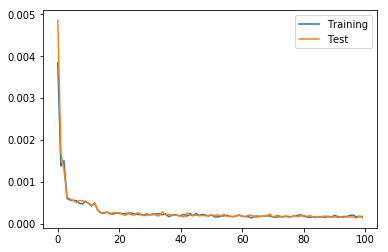

Training 73 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.14it/s]


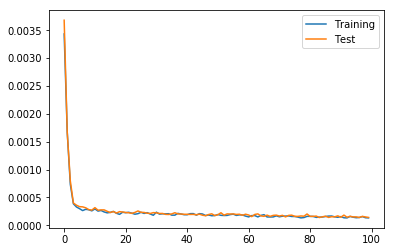

Training 74 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 40.27it/s]


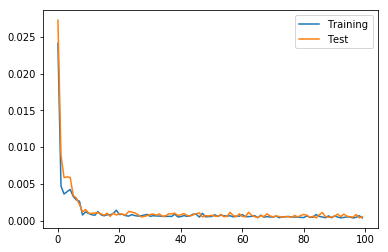

Training 75 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.48it/s]


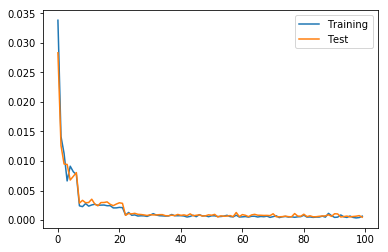

Training 76 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.28it/s]


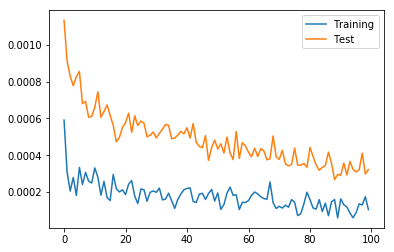

Training 77 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.77it/s]


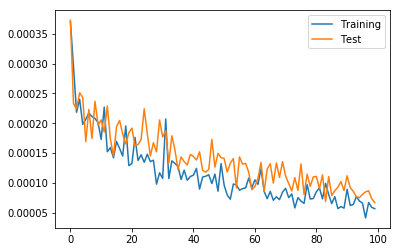

Training 78 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.76it/s]


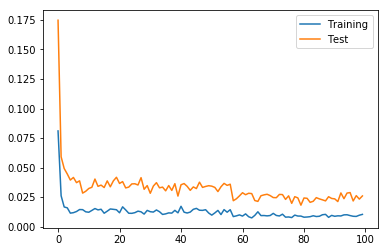

Training 79 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.89it/s]


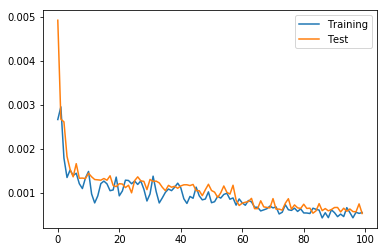

Training 80 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 38.67it/s]


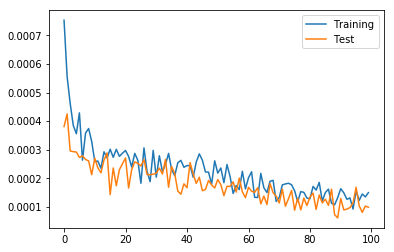

Training 81 out of 1329


100%|██████████| 10000/10000 [04:20<00:00, 38.41it/s]


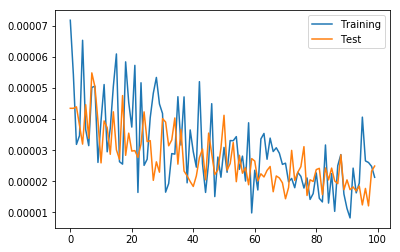

Training 82 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.31it/s]


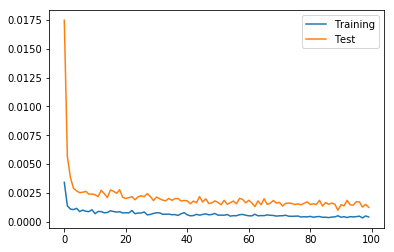

Training 83 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.21it/s]


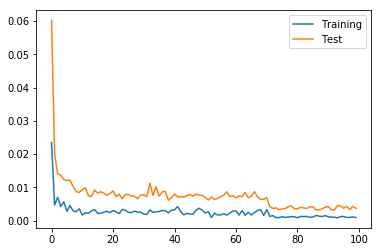

Training 84 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.10it/s]


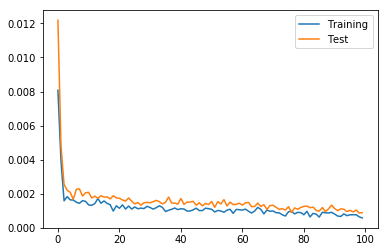

Training 85 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.03it/s]


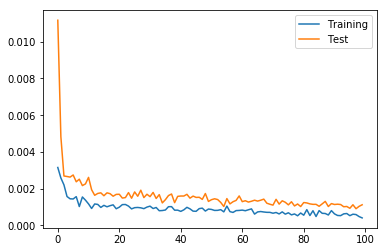

Training 86 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.18it/s]


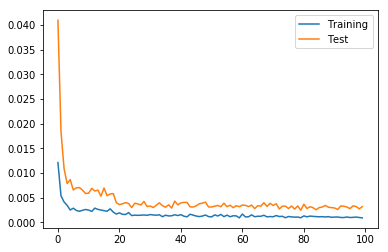

Training 87 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 35.18it/s]


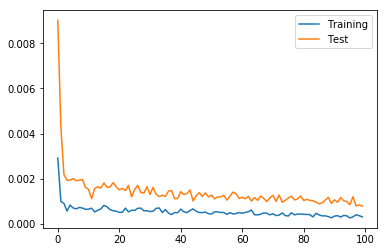

Training 88 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.89it/s]


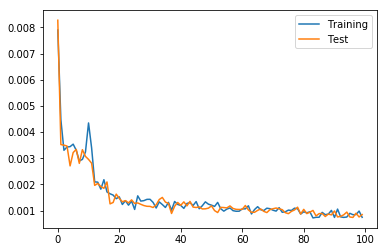

Training 89 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.81it/s]


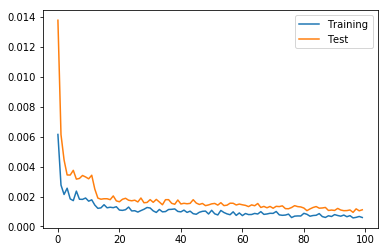

Training 90 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.11it/s]


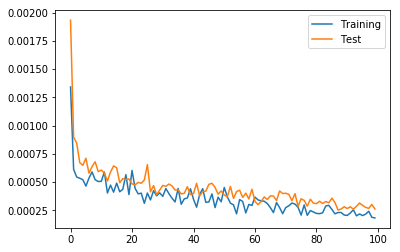

Training 91 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.63it/s]


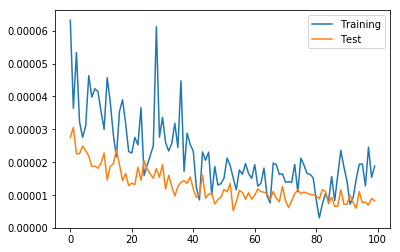

Training 92 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.92it/s]


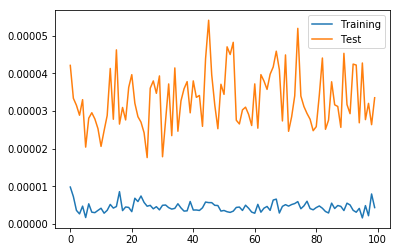

Training 93 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.96it/s]


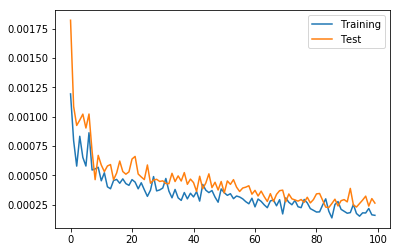

Training 94 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.90it/s]


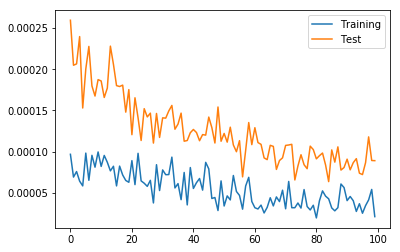

Training 95 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.69it/s]


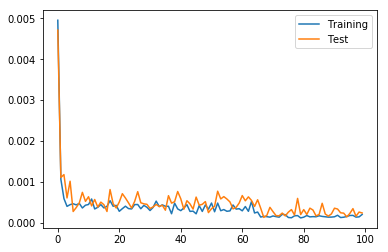

Training 96 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.82it/s]


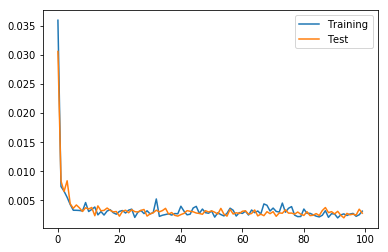

Training 97 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.75it/s]


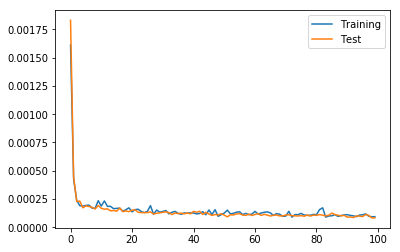

Training 98 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.95it/s]


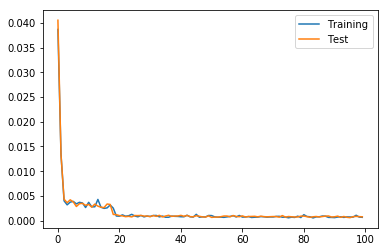

Training 99 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.71it/s]


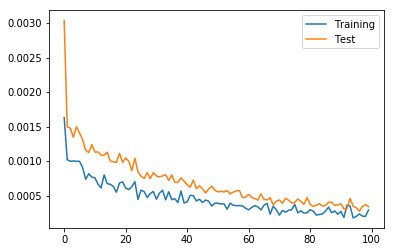

Training 100 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.06it/s]


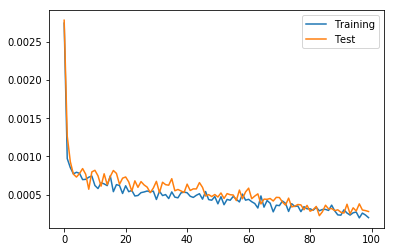

Training 101 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.96it/s]


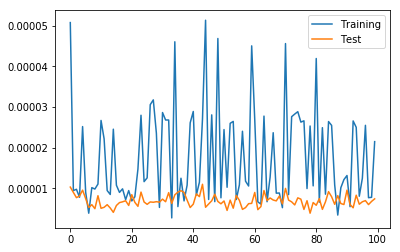

Training 102 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.76it/s]


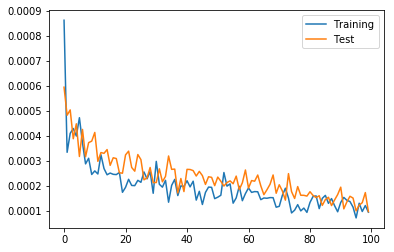

Training 103 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 38.49it/s]


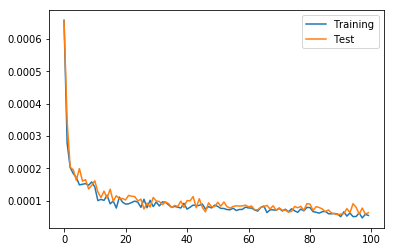

Training 104 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.82it/s]


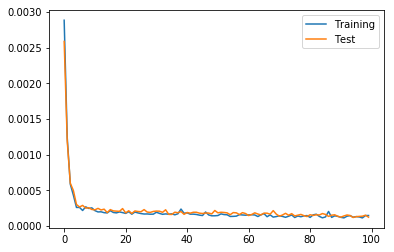

Training 105 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.39it/s]


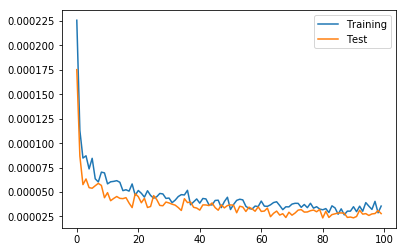

Training 106 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 38.77it/s]


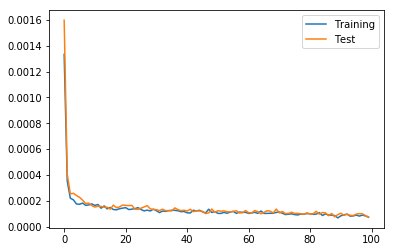

Training 107 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.78it/s]


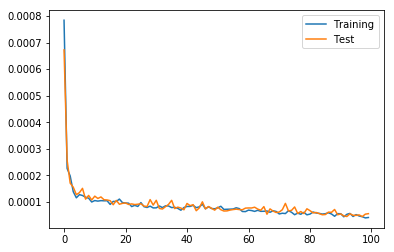

Training 108 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.78it/s]


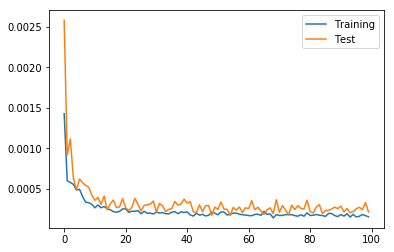

Training 109 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.78it/s]


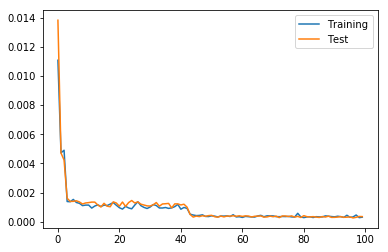

Training 110 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 36.72it/s]


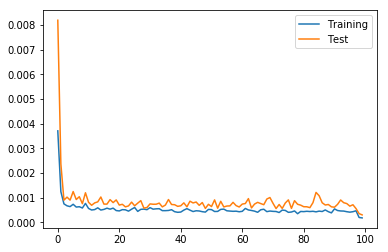

Training 111 out of 1329


100%|██████████| 10000/10000 [04:27<00:00, 38.27it/s]


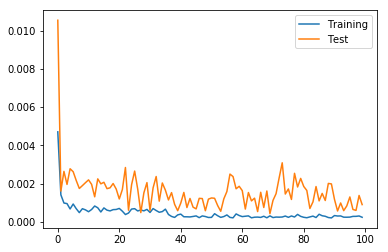

Training 112 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.84it/s]


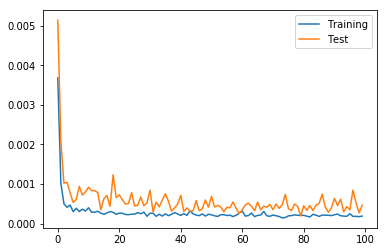

Training 113 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.93it/s]


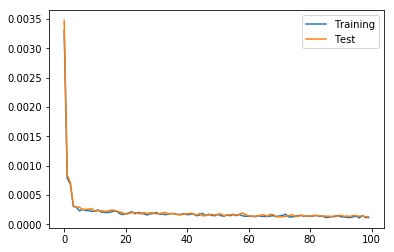

Training 114 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 36.29it/s]


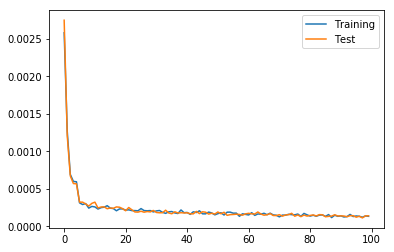

Training 115 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.93it/s]


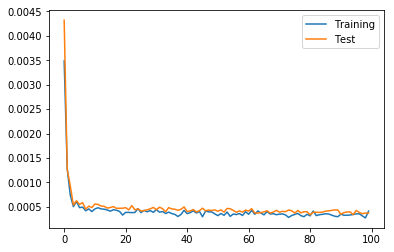

Training 116 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.97it/s]


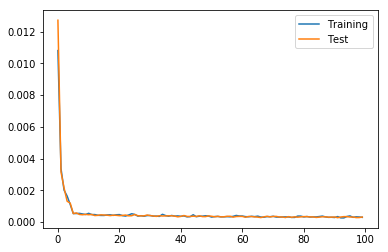

Training 117 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.04it/s]


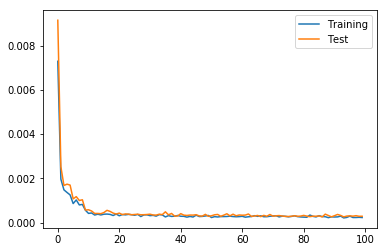

Training 118 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.08it/s]


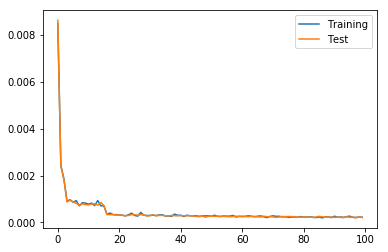

Training 119 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.94it/s]


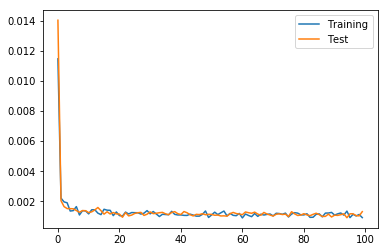

Training 120 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.08it/s]


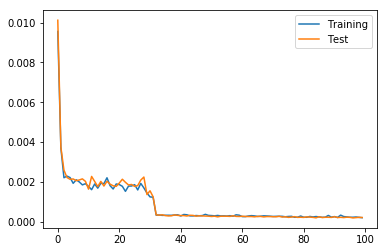

Training 121 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.87it/s]


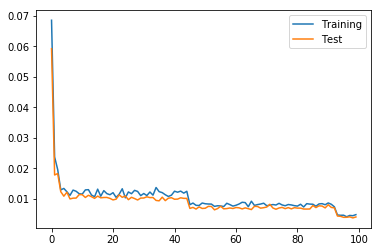

Training 122 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.80it/s]


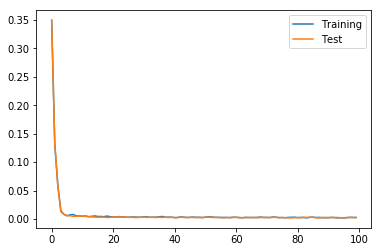

Training 123 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.01it/s]


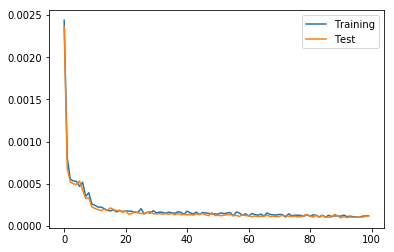

Training 124 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.79it/s]


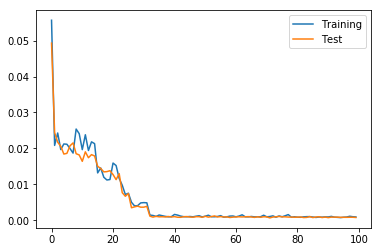

Training 125 out of 1329


100%|██████████| 10000/10000 [04:35<00:00, 36.34it/s]


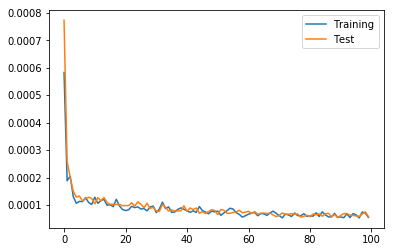

Training 126 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.09it/s]


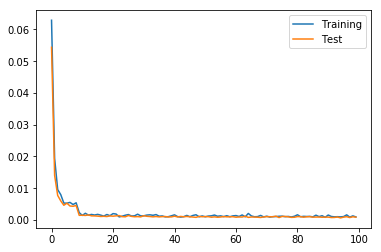

Training 127 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.00it/s]


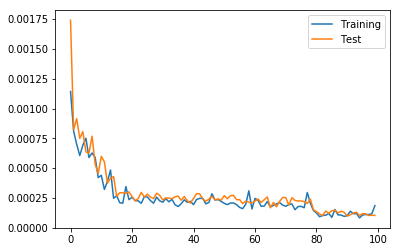

Training 128 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.22it/s]


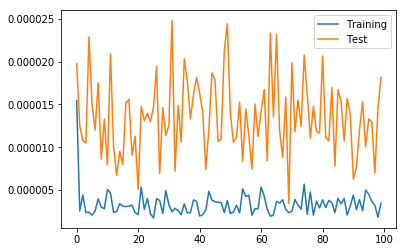

Training 129 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.65it/s]


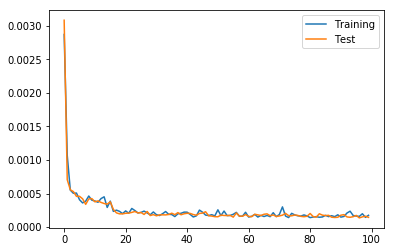

Training 130 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 36.51it/s]


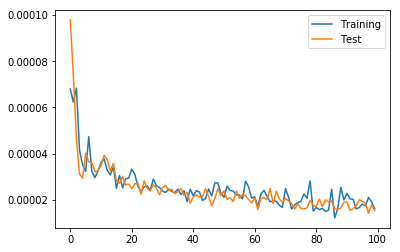

Training 131 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 39.13it/s]


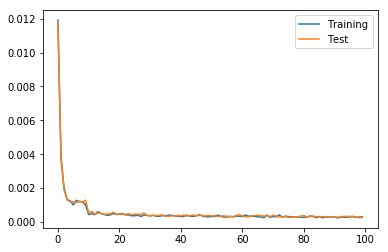

Training 132 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.04it/s]


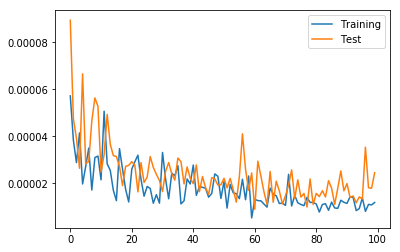

Training 133 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.27it/s]


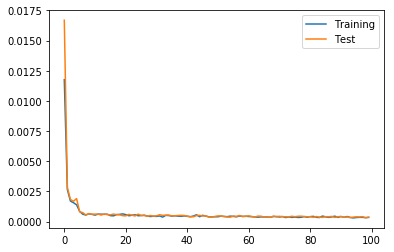

Training 134 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.16it/s]


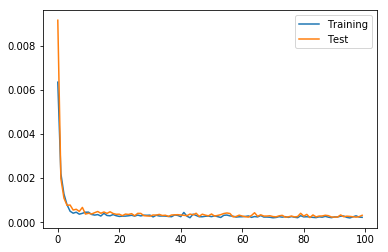

Training 135 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.04it/s]


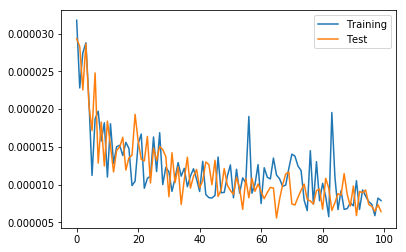

Training 136 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.90it/s]


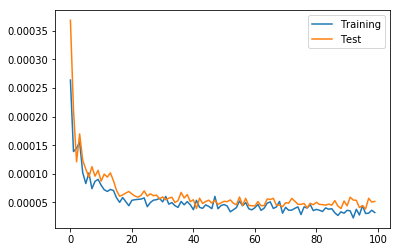

Training 137 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.01it/s]


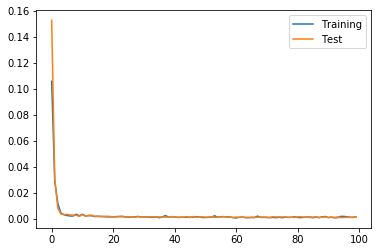

Training 138 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.90it/s]


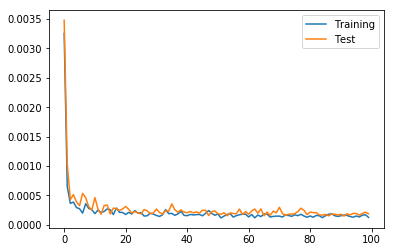

Training 139 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.90it/s]


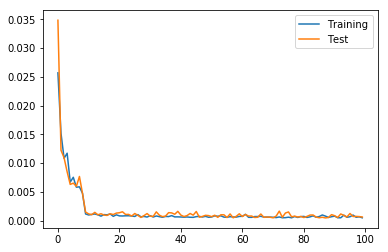

Training 140 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.92it/s]


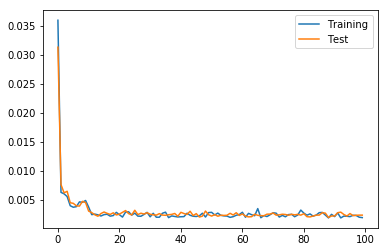

Training 141 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.99it/s]


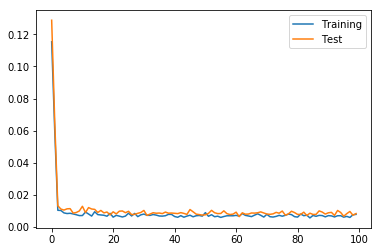

Training 142 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.14it/s]


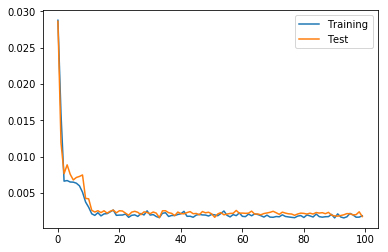

Training 143 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 39.22it/s]


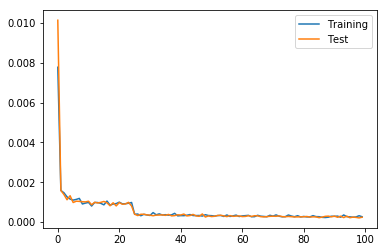

Training 144 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.18it/s]


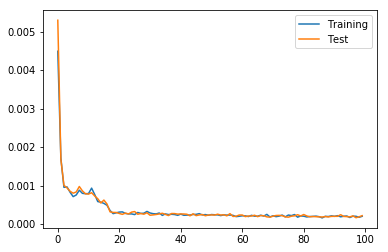

Training 145 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.01it/s]


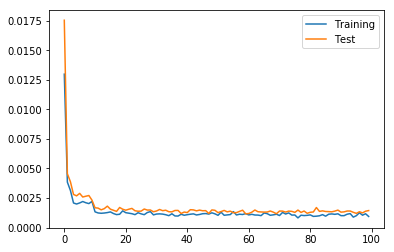

Training 146 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.54it/s]


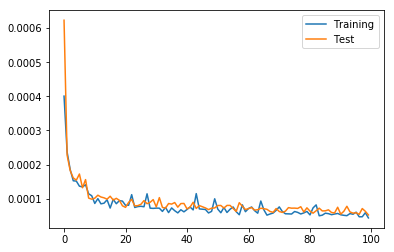

Training 147 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.10it/s]


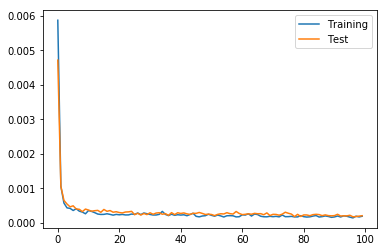

Training 148 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.34it/s]


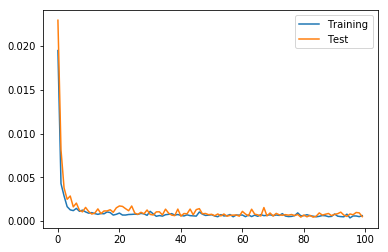

Training 149 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.07it/s]


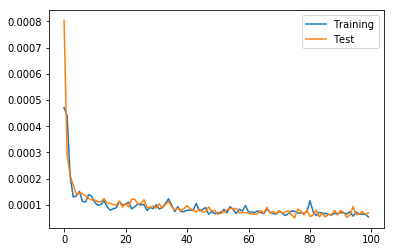

Training 150 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.14it/s]


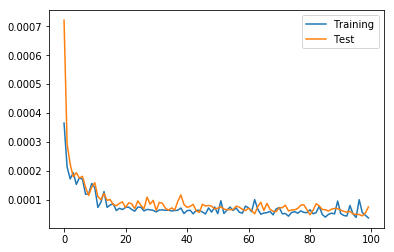

Training 151 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 38.20it/s]


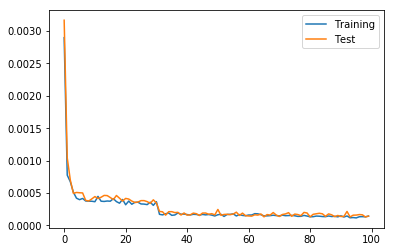

Training 152 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.21it/s]


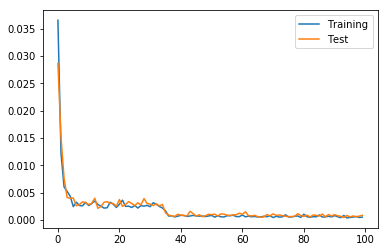

Training 153 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.06it/s]


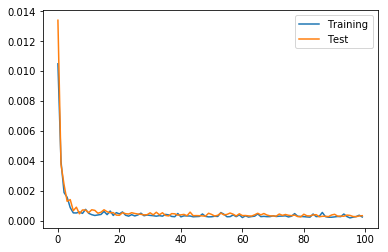

Training 154 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 37.93it/s]


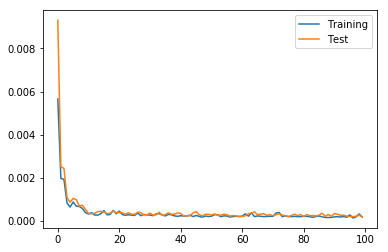

Training 155 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.61it/s]


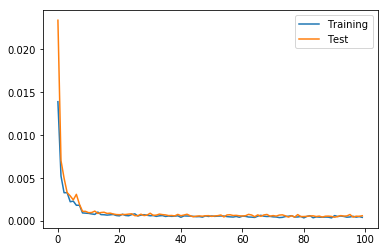

Training 156 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.98it/s]


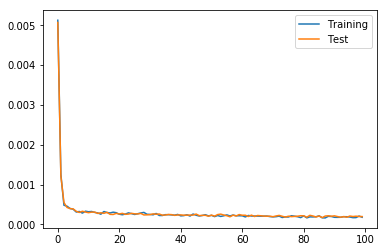

Training 157 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.06it/s]


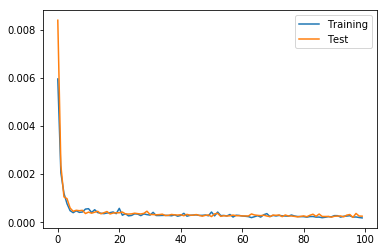

Training 158 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.46it/s]


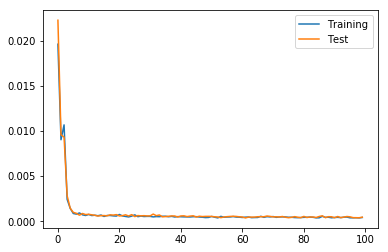

Training 159 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.16it/s]


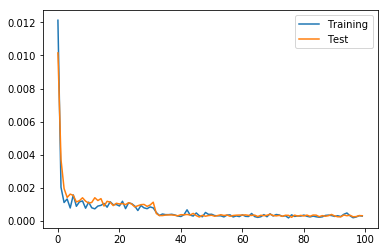

Training 160 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.14it/s]


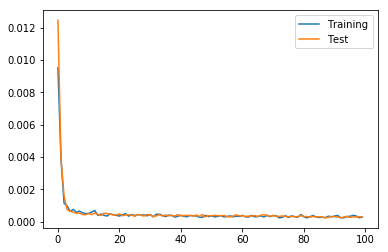

Training 161 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.12it/s]


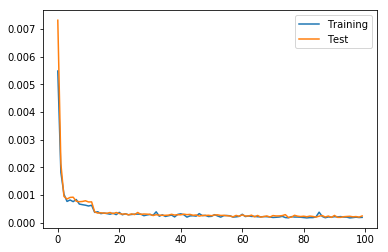

Training 162 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.23it/s]


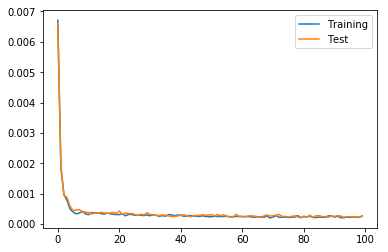

Training 163 out of 1329


100%|██████████| 10000/10000 [04:25<00:00, 37.65it/s]


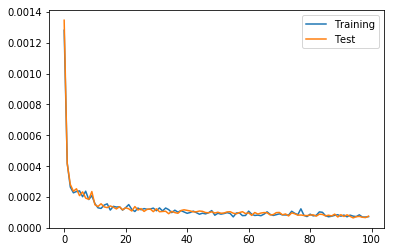

Training 164 out of 1329


100%|██████████| 10000/10000 [04:26<00:00, 37.56it/s]


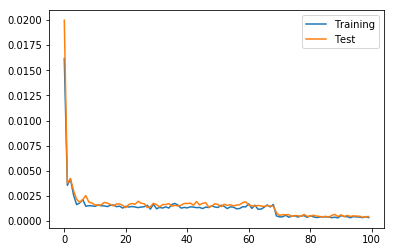

Training 165 out of 1329


100%|██████████| 10000/10000 [04:26<00:00, 37.50it/s]


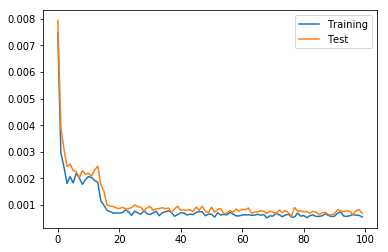

Training 166 out of 1329


100%|██████████| 10000/10000 [04:26<00:00, 37.53it/s]


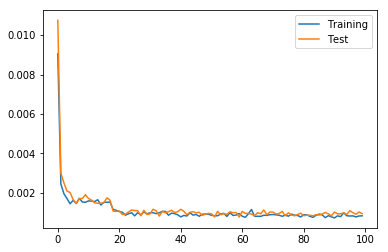

Training 167 out of 1329


100%|██████████| 10000/10000 [04:31<00:00, 36.88it/s]


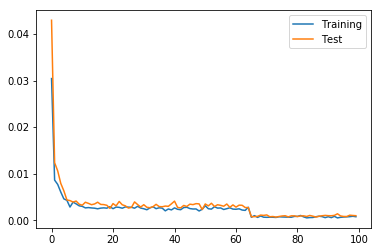

Training 168 out of 1329


100%|██████████| 10000/10000 [04:26<00:00, 37.58it/s]


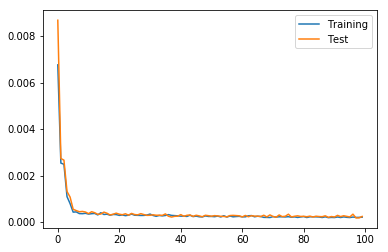

Training 169 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 40.32it/s]


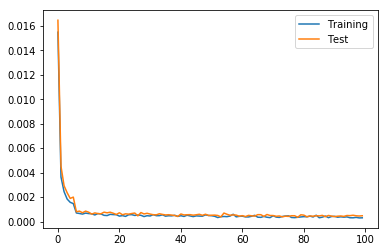

Training 170 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 41.25it/s]


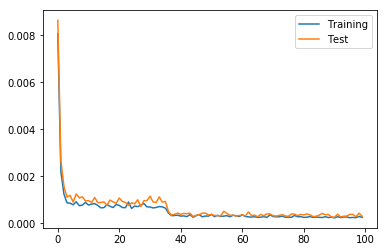

Training 171 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 40.95it/s]


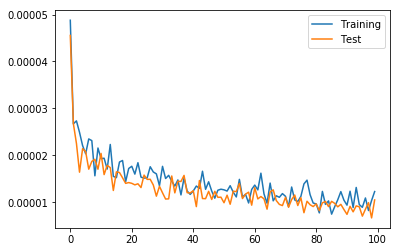

Training 172 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 40.91it/s]


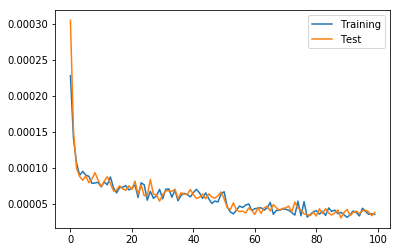

Training 173 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 40.89it/s]


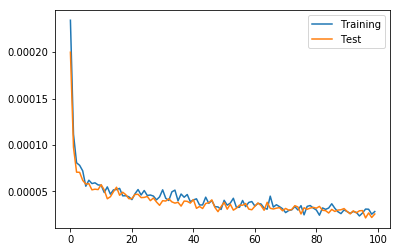

Training 174 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 41.23it/s]


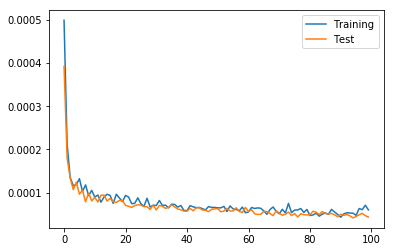

Training 175 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 40.93it/s]


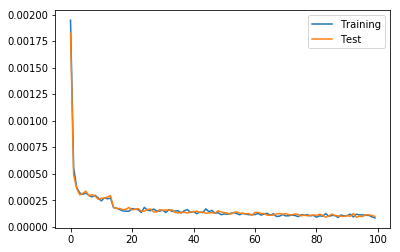

Training 176 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 40.29it/s]


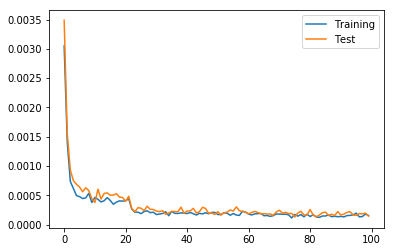

Training 177 out of 1329


100%|██████████| 10000/10000 [04:07<00:00, 40.60it/s]


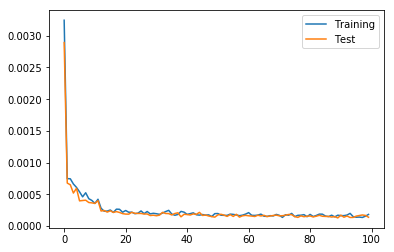

Training 178 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.63it/s]


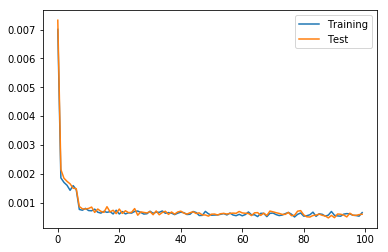

Training 179 out of 1329


100%|██████████| 10000/10000 [04:06<00:00, 41.48it/s]


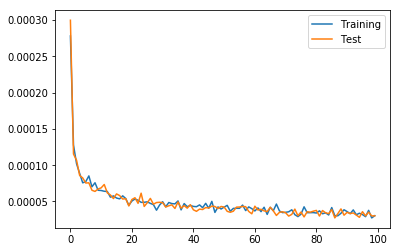

Training 180 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.37it/s]


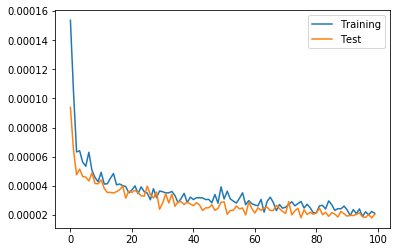

Training 181 out of 1329


100%|██████████| 10000/10000 [04:06<00:00, 40.61it/s]


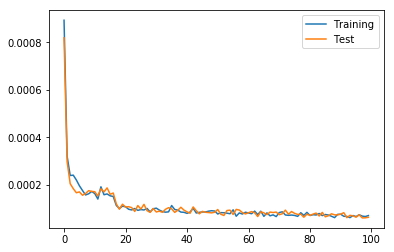

Training 182 out of 1329


100%|██████████| 10000/10000 [04:09<00:00, 40.06it/s]


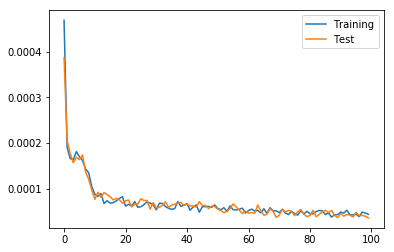

Training 183 out of 1329


100%|██████████| 10000/10000 [04:09<00:00, 40.01it/s]


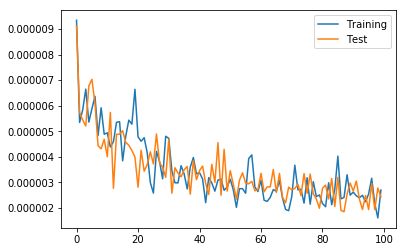

Training 184 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.68it/s]


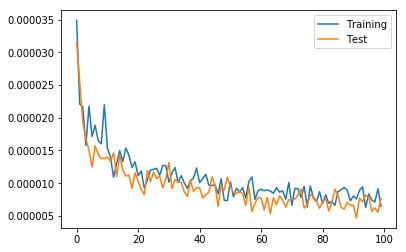

Training 185 out of 1329


100%|██████████| 10000/10000 [04:14<00:00, 39.25it/s]


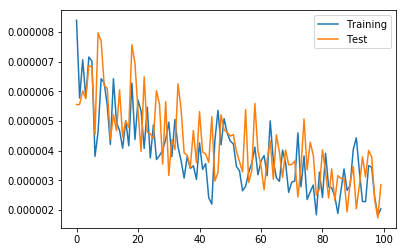

Training 186 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 39.80it/s]


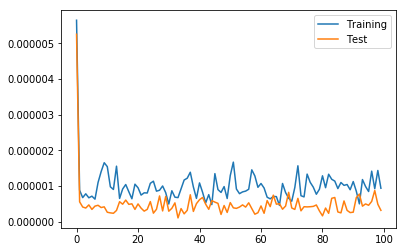

Training 187 out of 1329


100%|██████████| 10000/10000 [04:15<00:00, 42.48it/s]


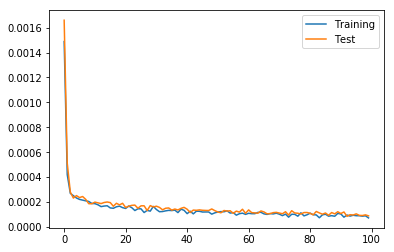

Training 188 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.48it/s]


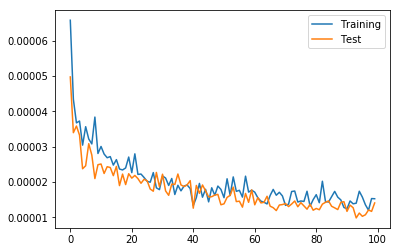

Training 189 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.33it/s]


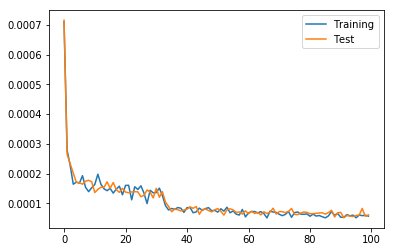

Training 190 out of 1329


100%|██████████| 10000/10000 [04:00<00:00, 41.50it/s]


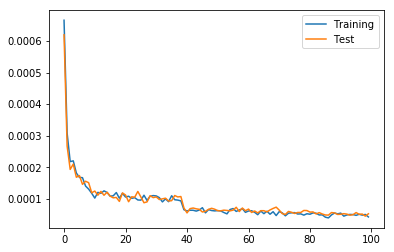

Training 191 out of 1329


100%|██████████| 10000/10000 [04:05<00:00, 40.77it/s]


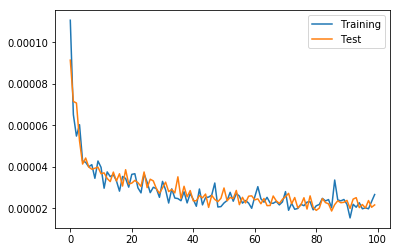

Training 192 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.79it/s]


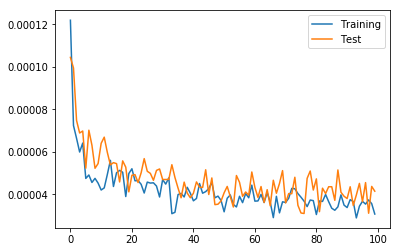

Training 193 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 38.65it/s]


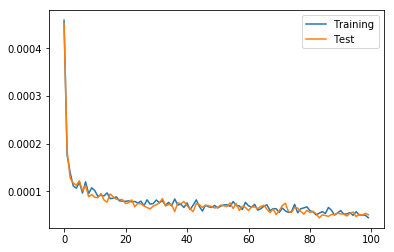

Training 194 out of 1329


100%|██████████| 10000/10000 [04:13<00:00, 39.47it/s]


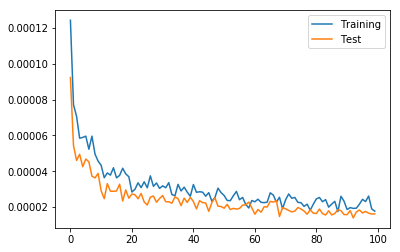

Training 195 out of 1329


100%|██████████| 10000/10000 [04:13<00:00, 39.50it/s]


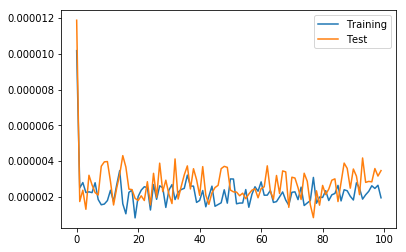

Training 196 out of 1329


100%|██████████| 10000/10000 [04:22<00:00, 38.17it/s]


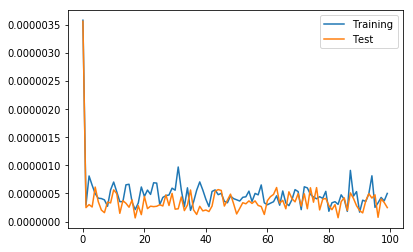

Training 197 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 39.86it/s]


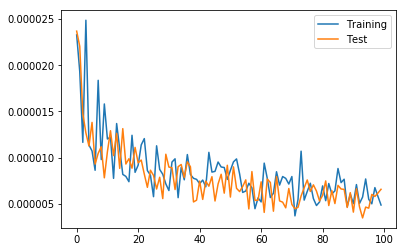

Training 198 out of 1329


100%|██████████| 10000/10000 [04:18<00:00, 33.14it/s]


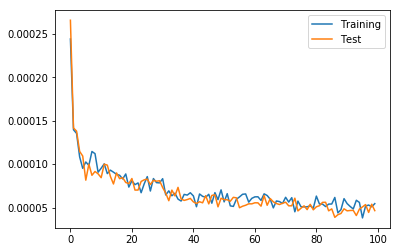

Training 199 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 38.84it/s]


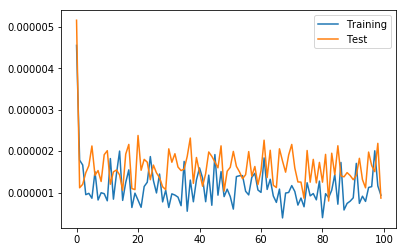

Training 200 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 41.25it/s]


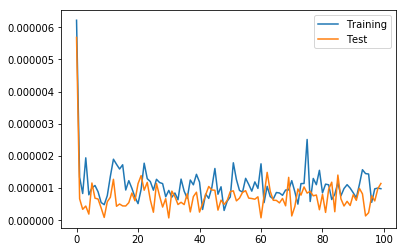

Training 201 out of 1329


100%|██████████| 10000/10000 [04:05<00:00, 40.81it/s]


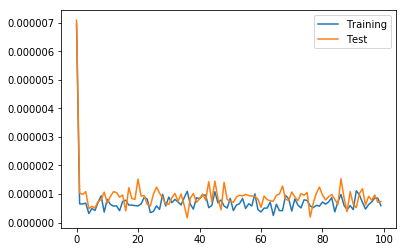

Training 202 out of 1329


100%|██████████| 10000/10000 [04:17<00:00, 41.73it/s]


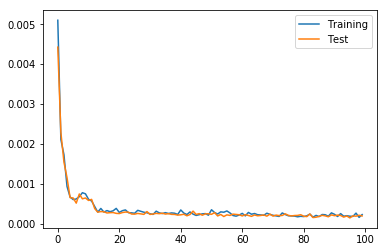

Training 203 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 39.78it/s]


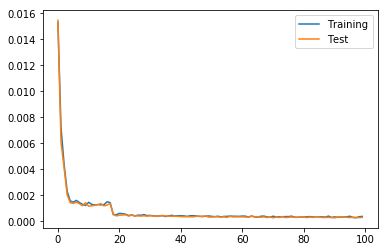

Training 204 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.31it/s]


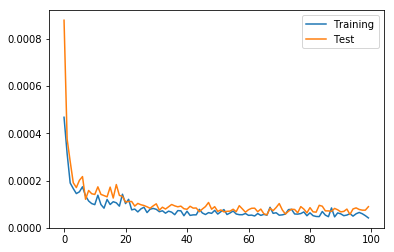

Training 205 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.06it/s]


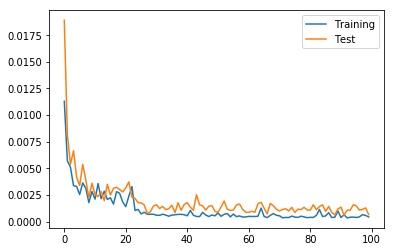

Training 206 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 41.13it/s]


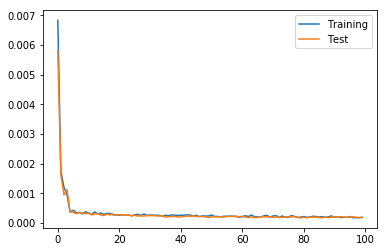

Training 207 out of 1329


100%|██████████| 10000/10000 [04:10<00:00, 39.98it/s]


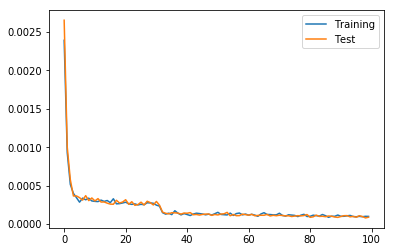

Training 208 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 41.33it/s]


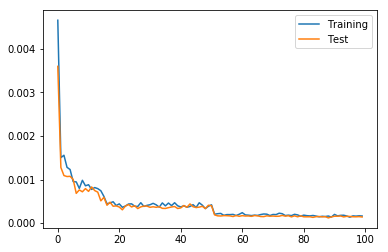

Training 209 out of 1329


100%|██████████| 10000/10000 [04:32<00:00, 36.76it/s]


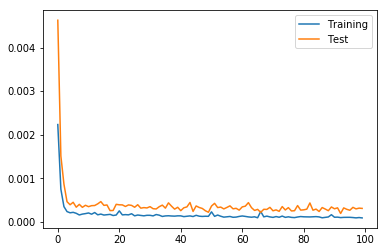

Training 210 out of 1329


100%|██████████| 10000/10000 [04:24<00:00, 37.87it/s]


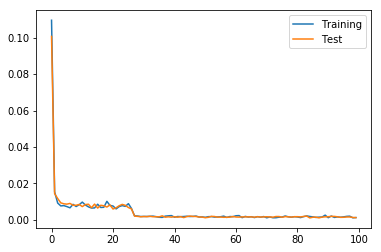

Training 211 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 39.76it/s]


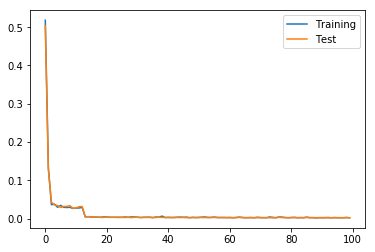

Training 212 out of 1329


100%|██████████| 10000/10000 [04:08<00:00, 40.20it/s]


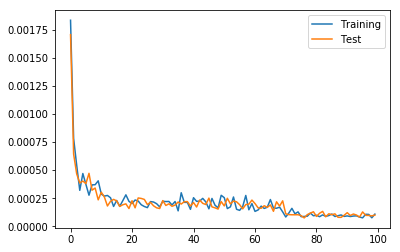

Training 213 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 39.69it/s]


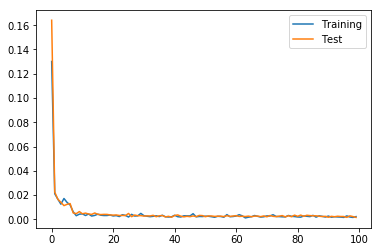

Training 214 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.38it/s]


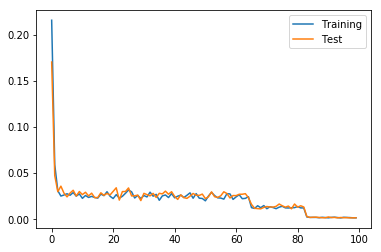

Training 215 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.95it/s]


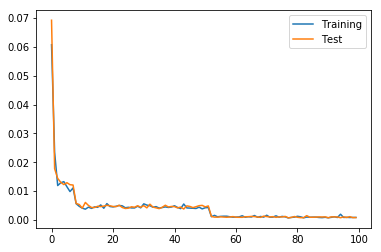

Training 216 out of 1329


100%|██████████| 10000/10000 [04:23<00:00, 37.88it/s]


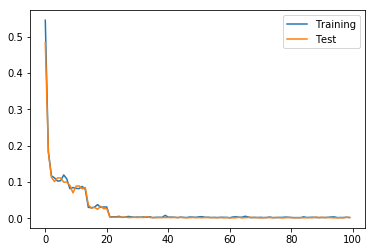

Training 217 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 39.84it/s]


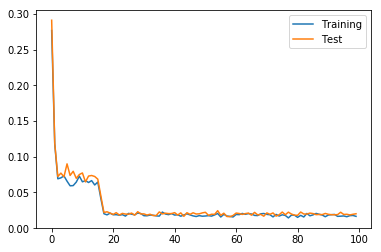

Training 218 out of 1329


100%|██████████| 10000/10000 [04:07<00:00, 40.33it/s]


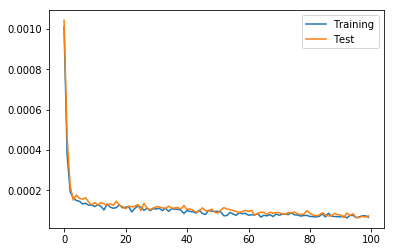

Training 219 out of 1329


100%|██████████| 10000/10000 [04:09<00:00, 40.10it/s]


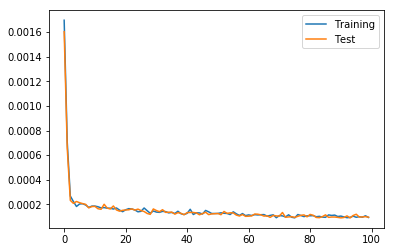

Training 220 out of 1329


100%|██████████| 10000/10000 [04:16<00:00, 38.96it/s]


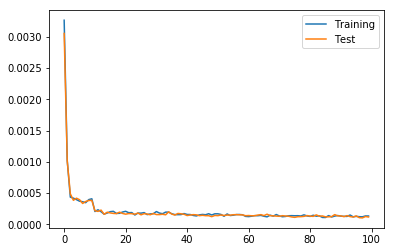

Training 221 out of 1329


100%|██████████| 10000/10000 [04:10<00:00, 39.87it/s]


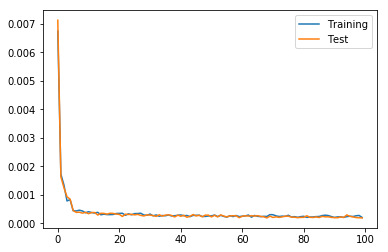

Training 222 out of 1329


100%|██████████| 10000/10000 [04:10<00:00, 39.87it/s]


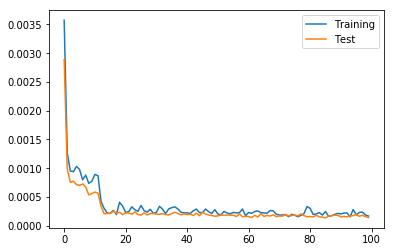

Training 223 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 41.29it/s]


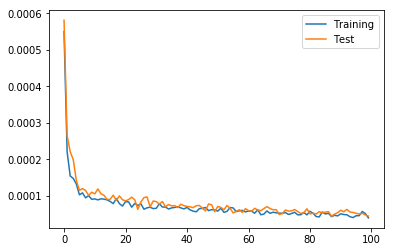

Training 224 out of 1329


100%|██████████| 10000/10000 [04:09<00:00, 40.03it/s]


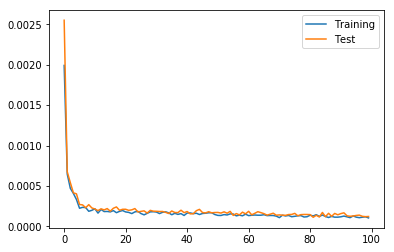

Training 225 out of 1329


100%|██████████| 10000/10000 [04:15<00:00, 39.09it/s]


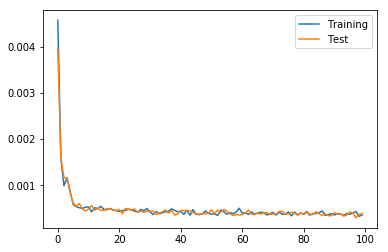

Training 226 out of 1329


100%|██████████| 10000/10000 [04:20<00:00, 34.74it/s]


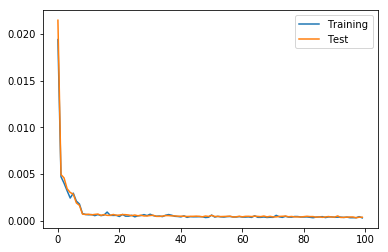

Training 227 out of 1329


100%|██████████| 10000/10000 [04:21<00:00, 38.21it/s]


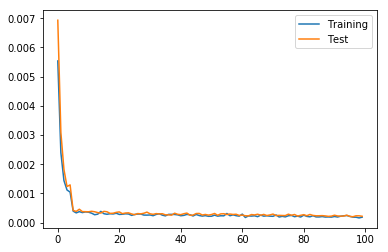

Training 228 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.52it/s]


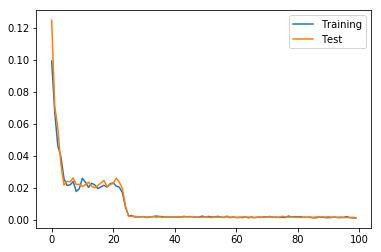

Training 229 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.58it/s]


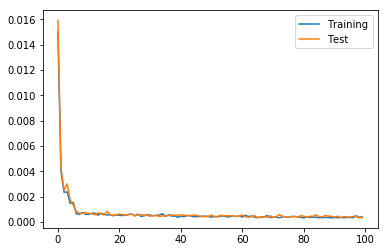

Training 230 out of 1329


100%|██████████| 10000/10000 [04:12<00:00, 39.63it/s]


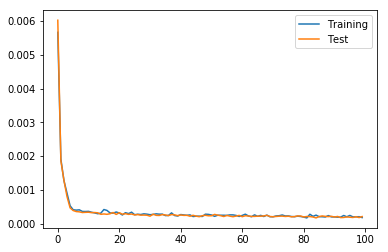

Training 231 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.44it/s]


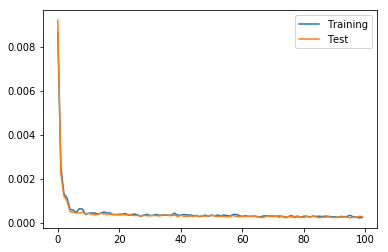

Training 232 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 42.79it/s]


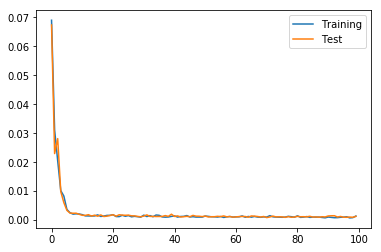

Training 233 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.32it/s]


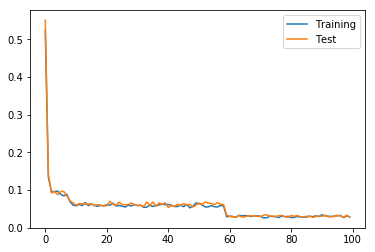

Training 234 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.00it/s]


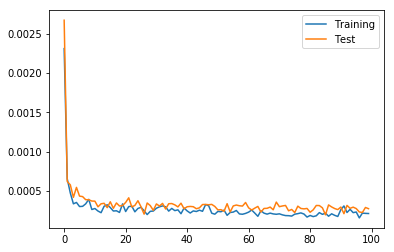

Training 235 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 39.73it/s]


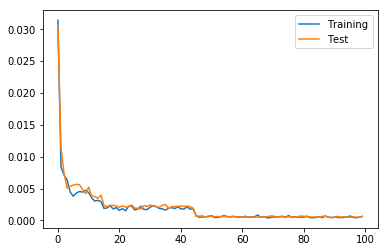

Training 236 out of 1329


100%|██████████| 10000/10000 [04:11<00:00, 40.48it/s]


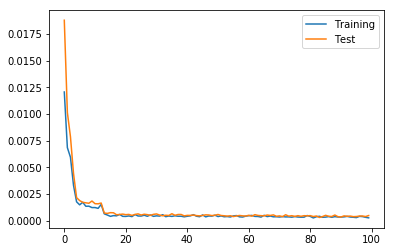

Training 237 out of 1329


100%|██████████| 10000/10000 [04:29<00:00, 37.17it/s]


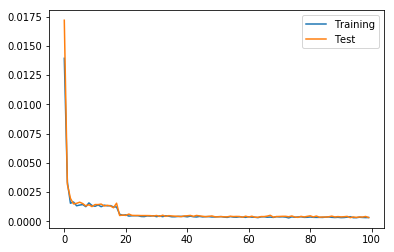

Training 238 out of 1329


100%|██████████| 10000/10000 [04:19<00:00, 38.54it/s]


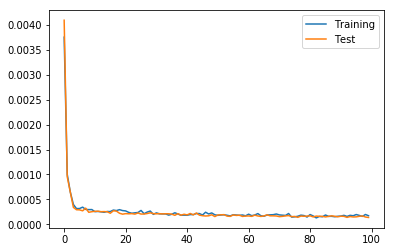

Training 239 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 40.82it/s]


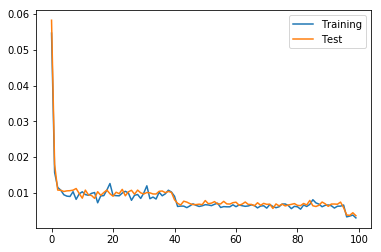

Training 240 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.04it/s]


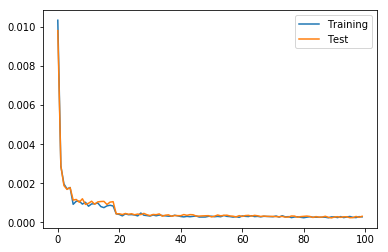

Training 241 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.31it/s]


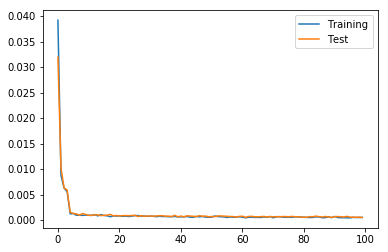

Training 242 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.40it/s]


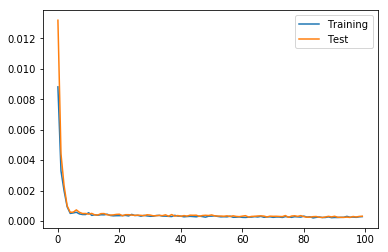

Training 243 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 41.20it/s]


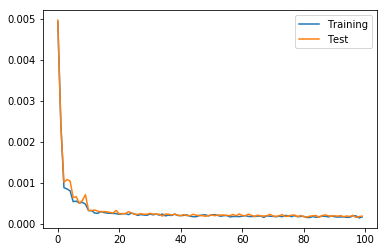

Training 244 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.91it/s]


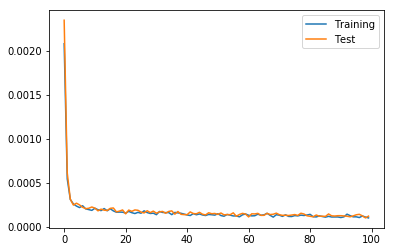

Training 245 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 41.21it/s]


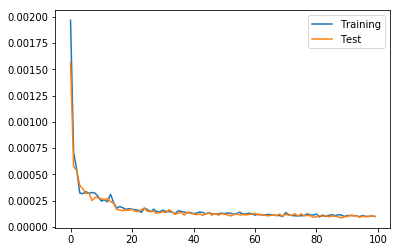

Training 246 out of 1329


100%|██████████| 10000/10000 [04:03<00:00, 41.07it/s]


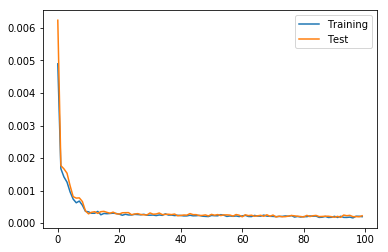

Training 247 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 42.62it/s]


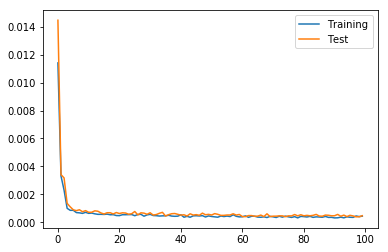

Training 248 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.33it/s]


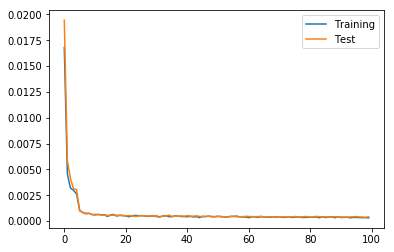

Training 249 out of 1329


100%|██████████| 10000/10000 [04:04<00:00, 38.92it/s]


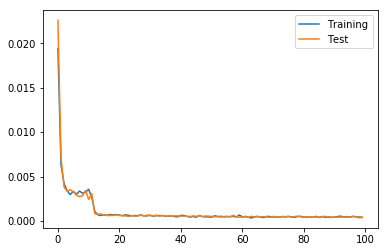

Training 250 out of 1329


100%|██████████| 10000/10000 [04:02<00:00, 41.31it/s]


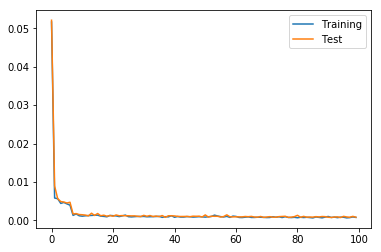

Training 251 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.80it/s]


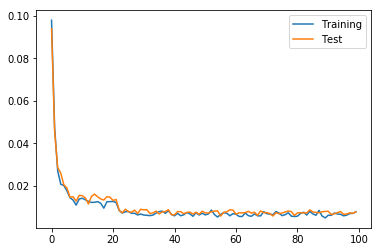

Training 252 out of 1329


100%|██████████| 10000/10000 [04:00<00:00, 41.51it/s]


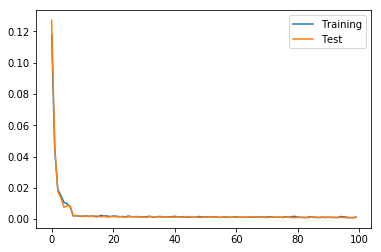

Training 253 out of 1329


100%|██████████| 10000/10000 [04:00<00:00, 41.58it/s]


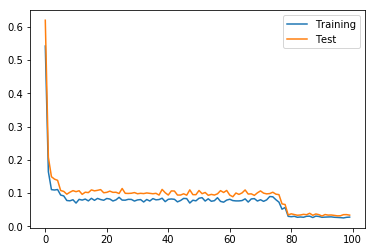

Training 254 out of 1329


100%|██████████| 10000/10000 [04:01<00:00, 41.43it/s]


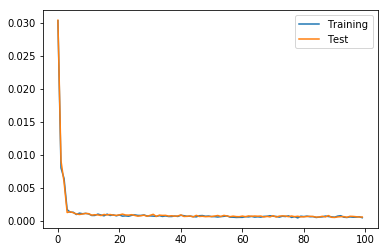

Training 255 out of 1329


100%|██████████| 10000/10000 [04:10<00:00, 39.90it/s]


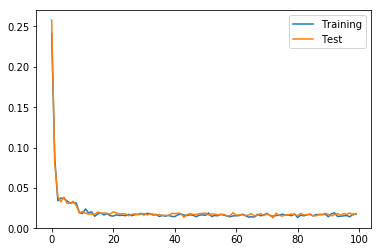

Training 256 out of 1329


 88%|████████▊ | 8841/10000 [03:48<00:28, 40.56it/s]

In [ ]:
model_list = []

for i in range(len(data_list)):
    print('Training {} out of {}'.format(i+1, len(data_list)))
    model = Model(data_list[i], data_list[i].geohash)
    model.train_model()
    model_list.append(model)

# Saving variables locally for data persistance

In [ ]:
with open('geohash_list.pkl', 'wb') as output_file:
    pickle.dump(geohash_list, output_file, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('data_objects.pkl', 'wb') as output_file:
    pickle.dump(data_list, output_file, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('model_objects.pkl', 'wb') as output_file:
    pickle.dump(model_list, output_file, pickle.HIGHEST_PROTOCOL)

# Visualising demand based on day of week

In [ ]:
# index should range from 0 to 1328
index = 0

# day of week should range from 1-7
dayofweek = 1
dayofweek_list = list(range(dayofweek,62,7))

day_by_time = data_list[index].data_by_time(dayofweek_list)
plt.figure(figsize=(30,10))
day_by_time.boxplot(column=list(day_by_time.columns))
plt.xticks(rotation=90)

In [ ]:
for day in dayofweek_list:
    data_list[index].plot_demand(day)

Potential input features: day of week, mean demand, std deviation, observed demand from T-1,...